In [55]:
import numpy as np
from scipy import signal
import pywt
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import entropy
from PyEMD import EMD

Die Pipeline bildet das Schema aus dem folgenden Bild ab. Dabei dient die Pipeline zur feature bestimmung für die regressions models

![image info](./images/pipeline.PNG)

# Raw EEG

Extracting EDF parameters from e:\11 Semester\Master-Thesis\Vorbereitung\working-with-eeg\sampleData\S010R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


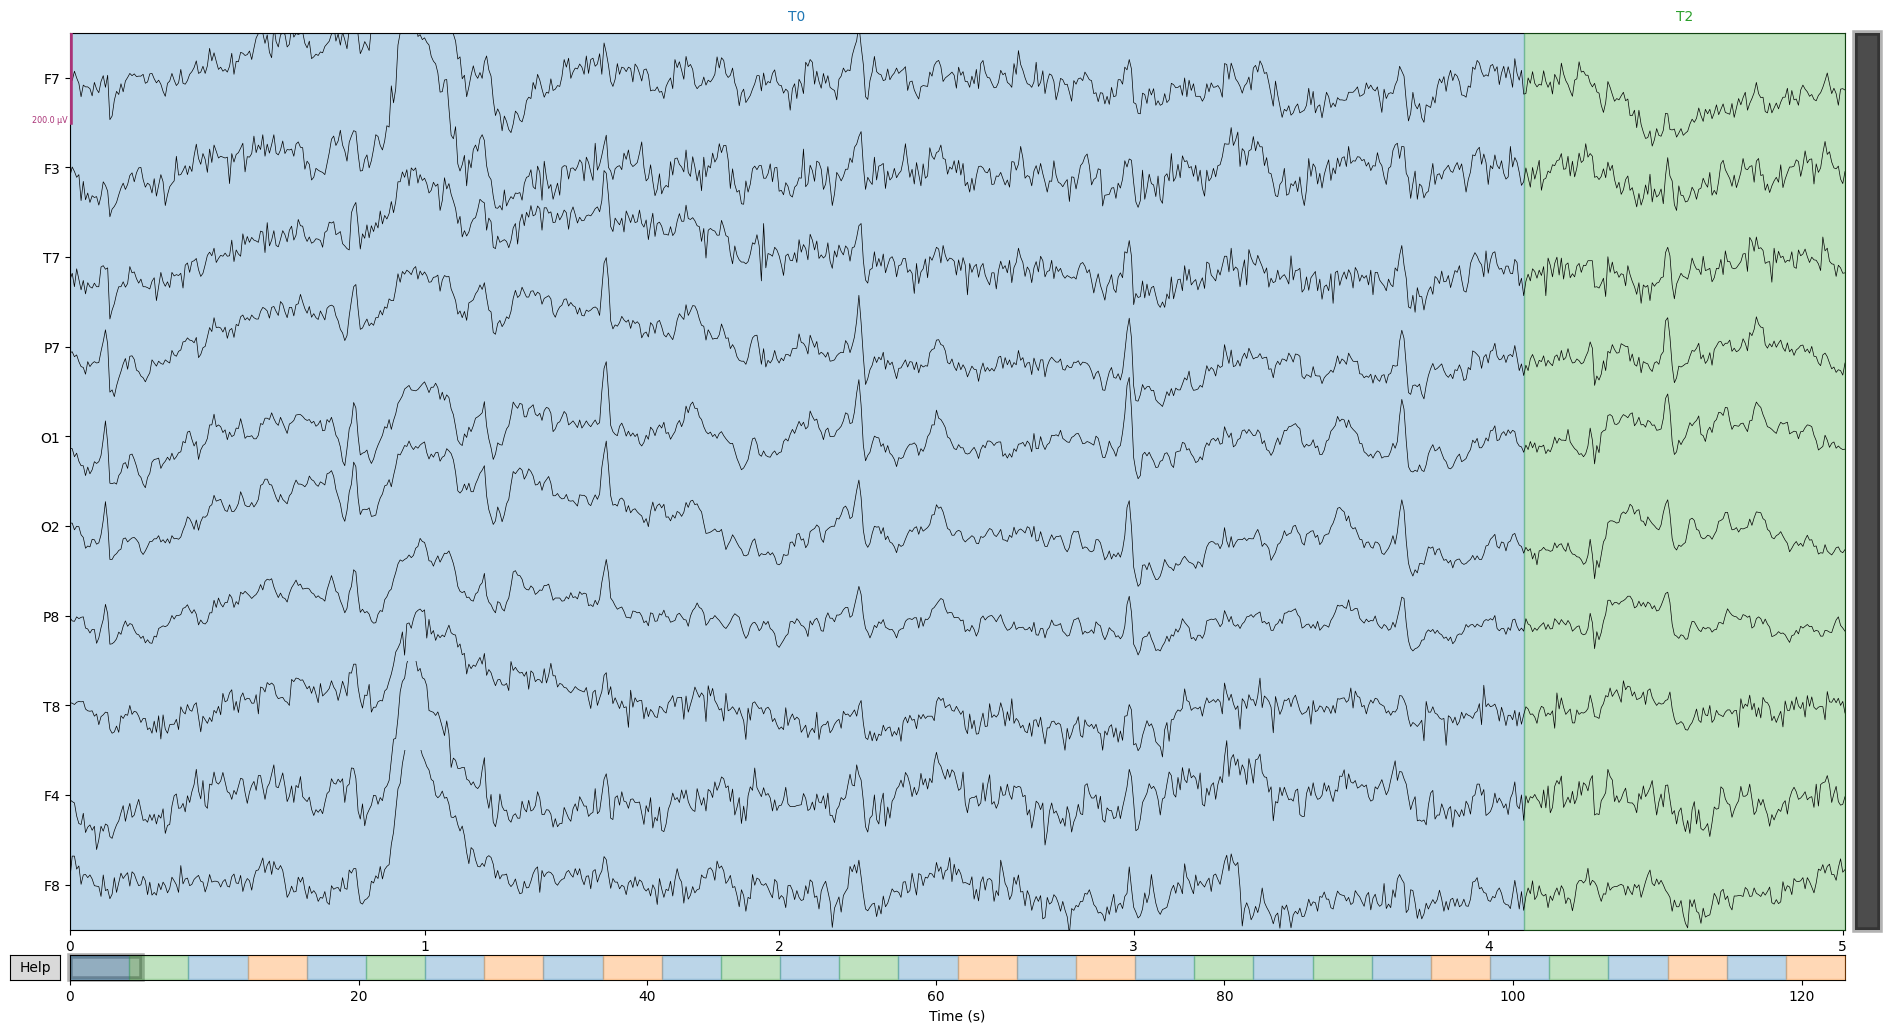

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


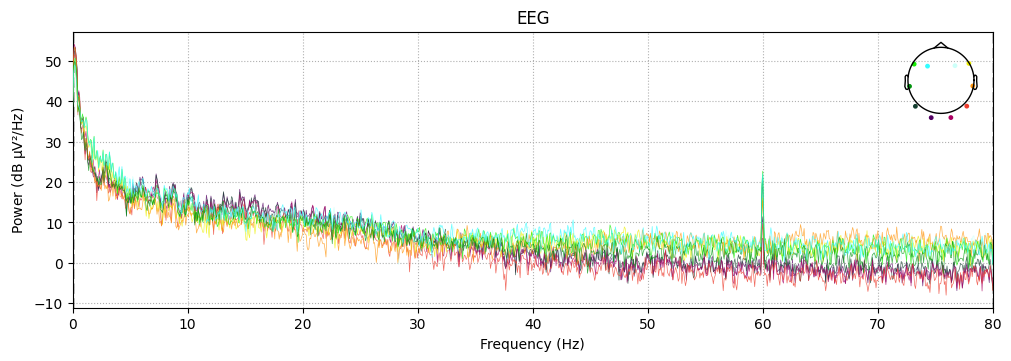

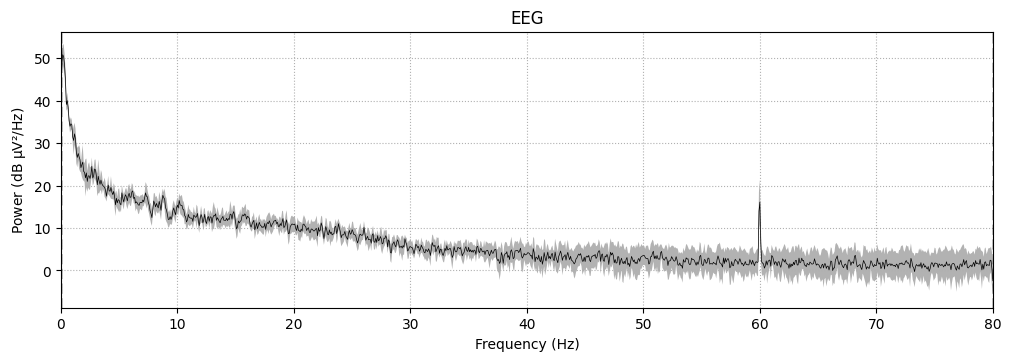

In [56]:
def load_and_format_raw_data(file_path, desired_channels):
    # load the edf file with mne
    raw = mne.io.read_raw_edf(file_path, preload=True)

    print(raw.ch_names)

    # rename channels without "." (dot) in the name
    new_ch_names = {ch_name: ch_name.replace('.', '') for ch_name in raw.info['ch_names']}
    raw.rename_channels(new_ch_names)

    # pick desired channels
    raw.pick_channels(desired_channels)

    # define channel positions (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in desired_channels}

    # create new montage with the channel positions
    new_montage = mne.channels.make_dig_montage(positions, coord_frame='head')

    # set montage
    raw.set_montage(new_montage)

    return raw

file_path = "sampleData/S010R10.edf"

# define list of desired channels (10-20 system; desired channels are the 14 emotiv epoc channels, but there are only 10 of them in the dataset)
desired_channels = ["F7", "F3", "T7", "P7", "O1", "O2", "P8", "T8", "F4", "F8"]

raw = load_and_format_raw_data(file_path, desired_channels)

# show the original raw data and the power spectral density of the original data
raw.plot(title="Originaldaten", duration=5, n_channels=len(desired_channels), scalings=0.0001)
raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)
plt.show()

# Pre-processing
"To compute the feature vector from the EEG signal, we started by performing a pre-processing step (Figure 2). Here, we first detrended the signal and eliminated the 50 Hz power line frequency by applying a notch filter. Then, to remove artifacts, we applied adaptive filtering techniques (for ECG artifacts) and wavelet thresholding (for EOG artifacts)."

# Detrended signal

Detrending entfernt systematische Trends oder langsame Veränderungen in den Daten, die nicht Teil der interessierenden Signale sind. Diese Trends können durch externe Faktoren oder durch das Messsystem selbst verursacht werden.

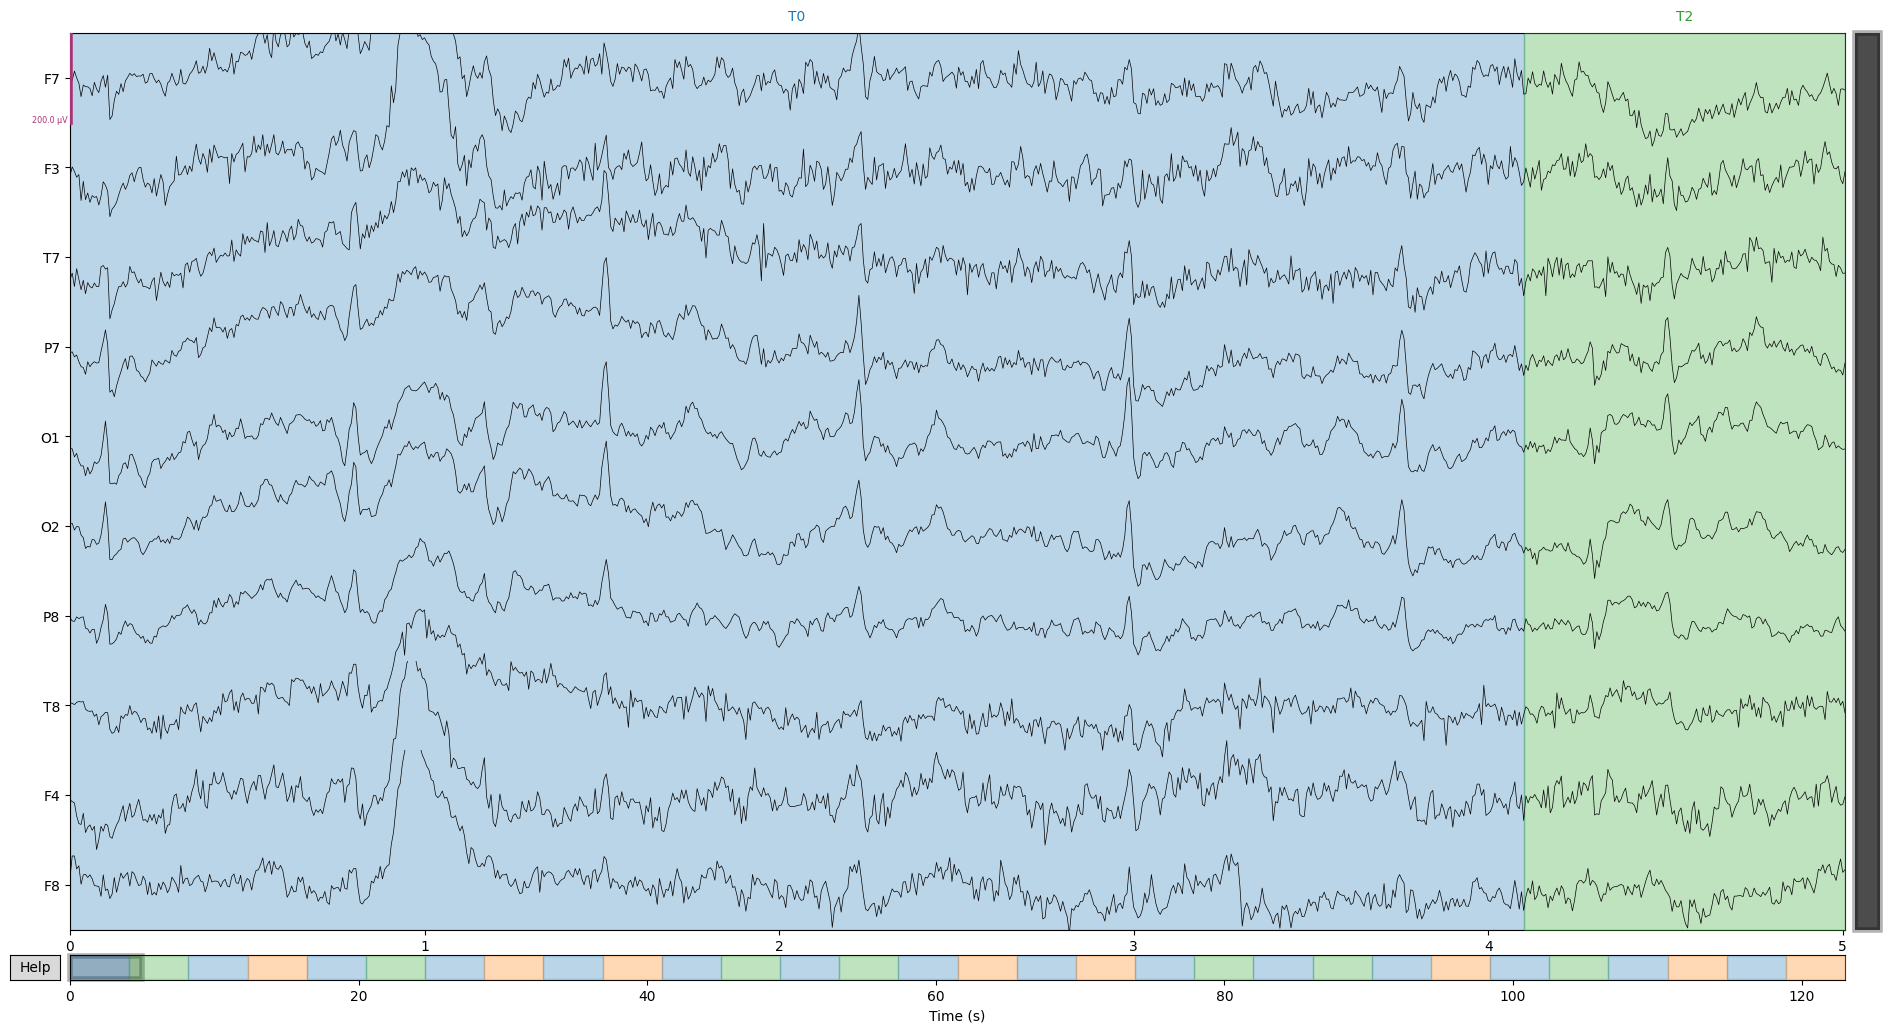

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


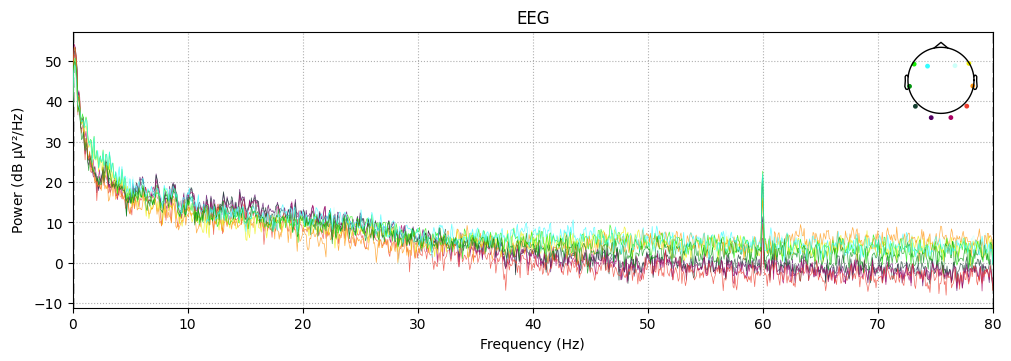

In [57]:
raw.apply_function(signal.detrend, overwrite_data=True)

raw.plot(title="Detrended data", duration=5, n_channels=len(desired_channels), scalings=0.0001)
raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
plt.show()

# notch filter

Der Notch filter wird hier verwendet um die Netzwerkspannung bei 60Hz zu entfernen

Notch filter sind so konzipiert, dass sie ein sehr schmales Frequenzband dämpfen und Frequenzen außerhalb dieses Bandes mit minimaler Änderung passieren lassen. Ein 60-Hz-Kerbfilter reduziert beispielsweise Signale um diese Frequenz herum erheblich.

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



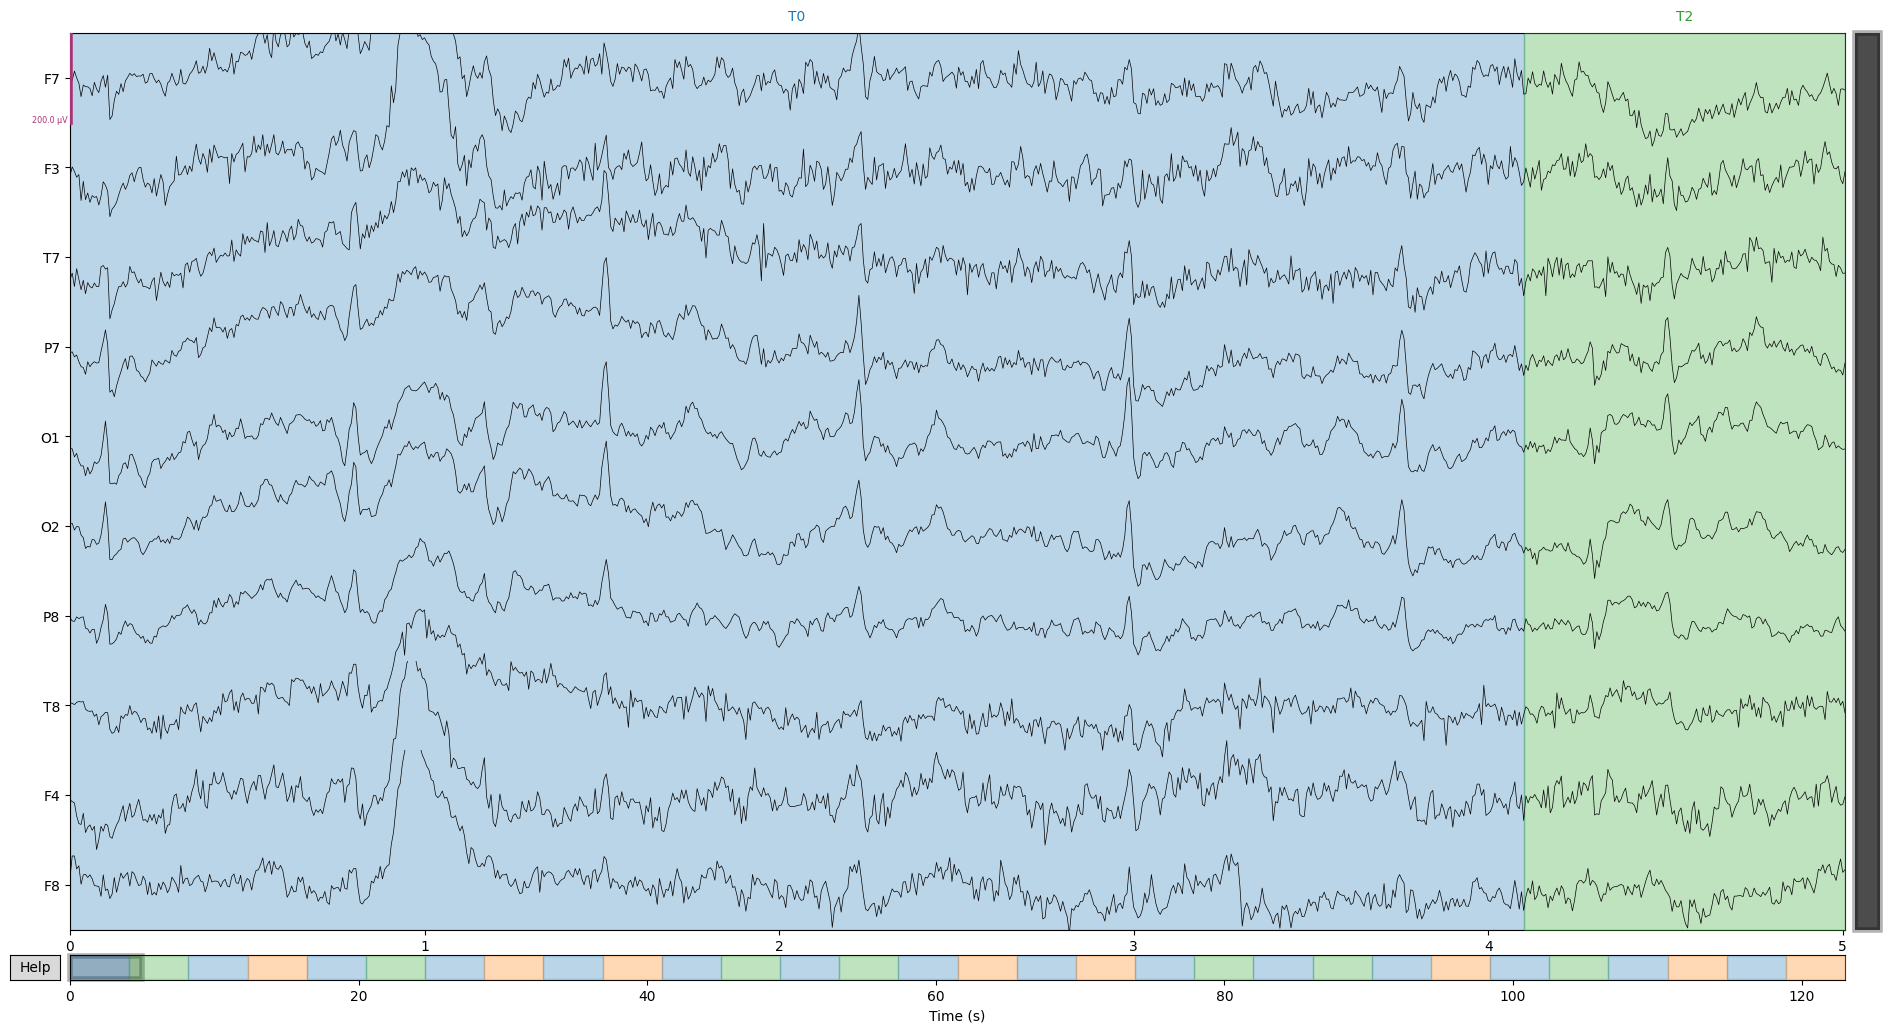

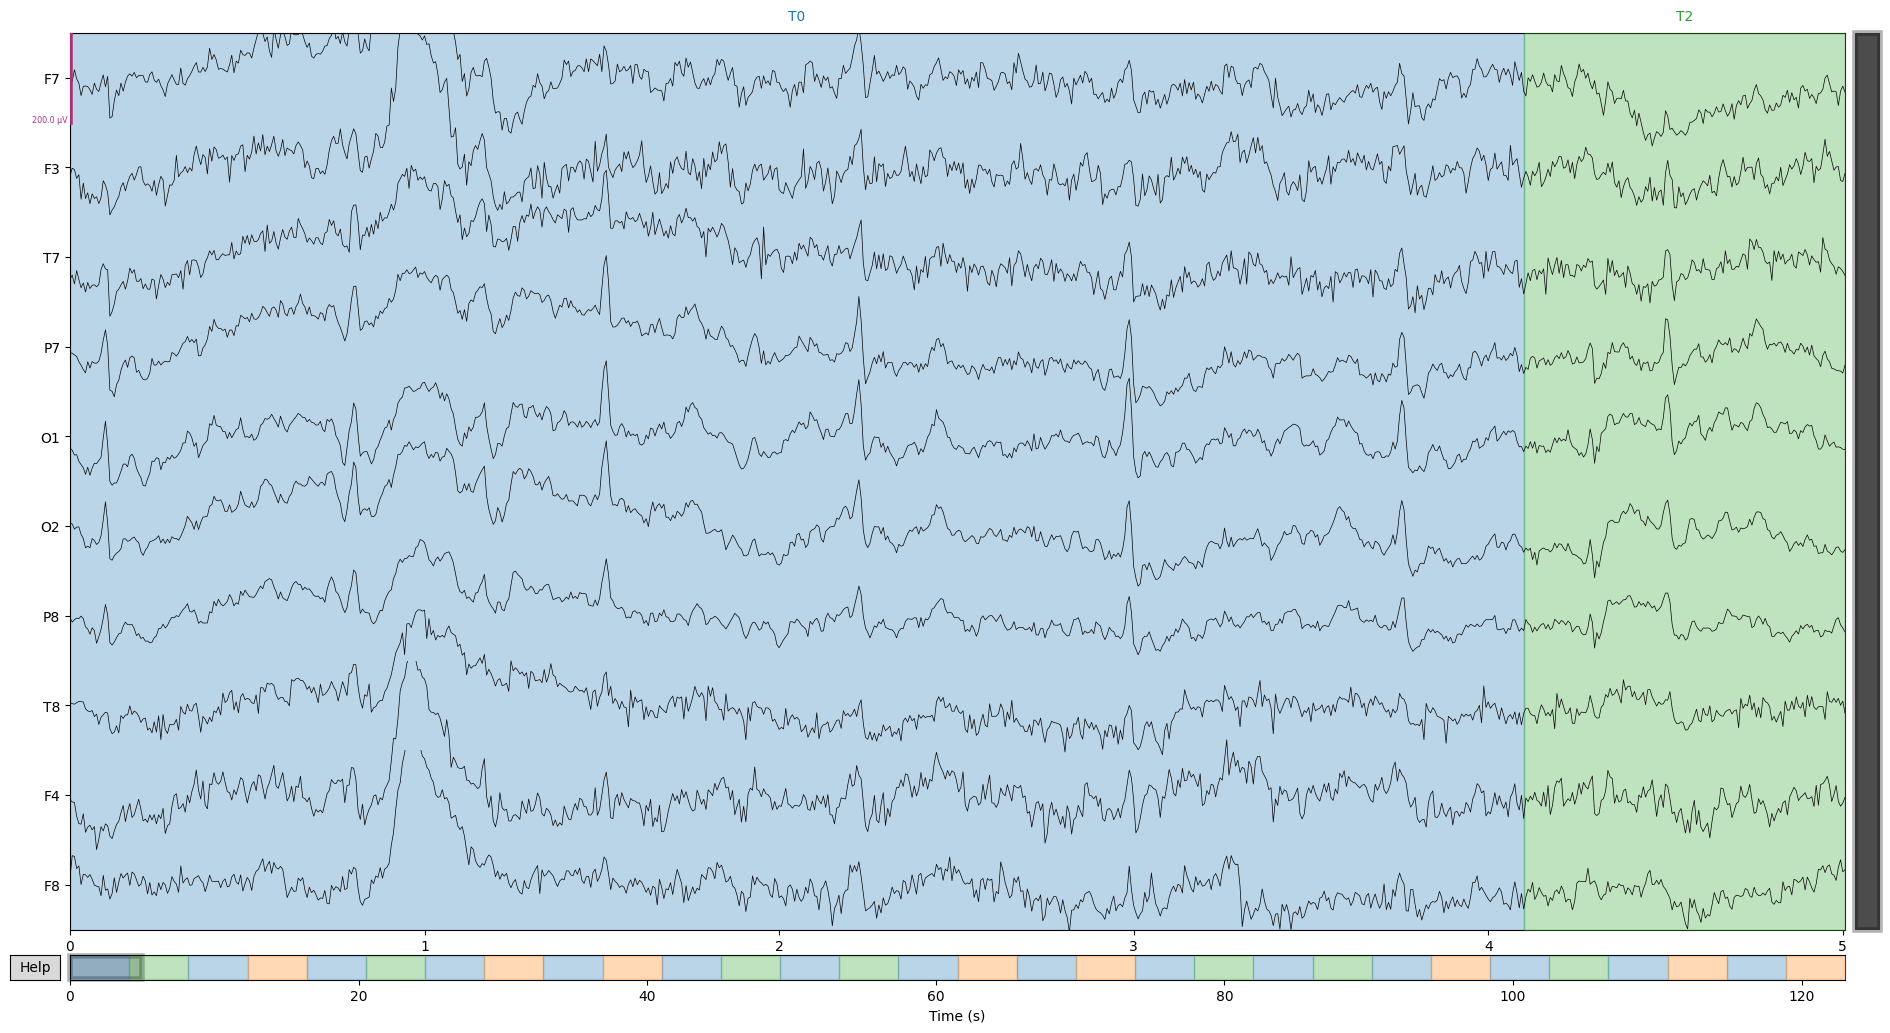

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


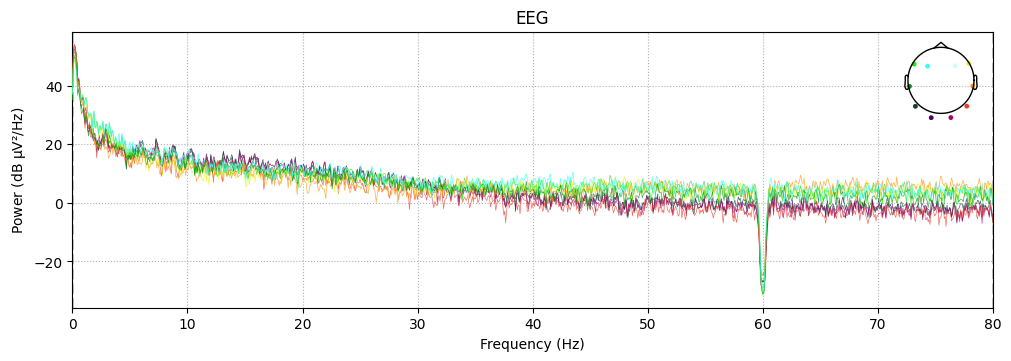

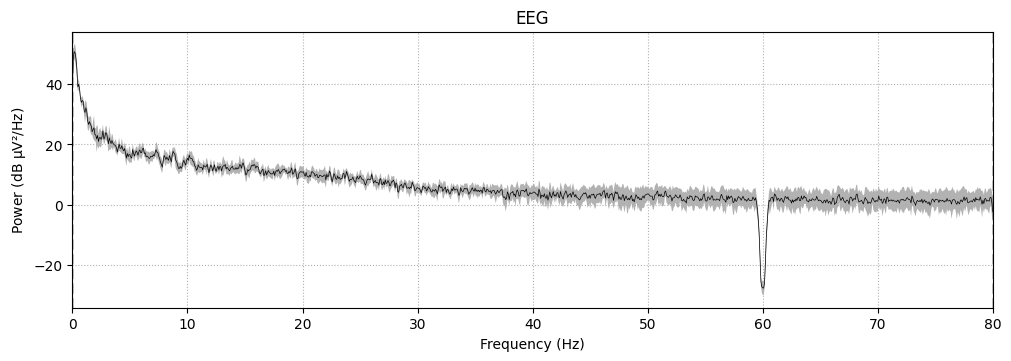

In [58]:
def notched_eeg(raw_data):

    # Notch filter
    notched_raw = raw_data.copy()
    notched_raw.notch_filter(60)

    raw_data.plot(title="Originaldaten", duration=5, n_channels=len(desired_channels), scalings=0.0001)
    notched_raw.plot(title="Detrended", duration=5, n_channels=len(desired_channels), scalings=0.0001)
    # raw_data.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
    # raw_data.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)
    notched_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
    notched_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)
    plt.show()

    # plot_comparison(detrended_raw, notched_raw, "Notch Filter")
    return notched_raw


notched_raw = notched_eeg(raw)

# adaptive filtering

In [59]:
# from scipy import signal
# import pywt
# import mne
# import matplotlib.pyplot as plt

# def adaptive_filter_ecg(eeg_data, ecg_reference, filter_length=10, step_size=0.1):
#     # Initialisiere den Filterkoeffizienten
#     w = np.zeros(filter_length)
    
#     # Anwenden des LMS-Algorithmus
#     filtered_eeg = np.zeros_like(eeg_data)
#     for i in range(len(eeg_data)):
#         # Berechne die Filterausgabe
#         y = np.dot(w, ecg_reference[i:i+filter_length])
        
#         # Berechne den Fehler
#         e = eeg_data[i] - y
        
#         # Aktualisiere die Filterkoeffizienten
#         w = w + step_size * e * ecg_reference[i:i+filter_length]
        
#         # Speichere das gefilterte Signal
#         filtered_eeg[i] = e
    
#     return filtered_eeg

# def load_and_format_raw_data(file_path, desired_channels):
#     # load the edf file with mne
#     raw = mne.io.read_raw_edf(file_path, preload=True)

#     print(raw.ch_names)

#     # rename channels without "." (dot) in the name
#     new_ch_names = {ch_name: ch_name.replace('.', '') for ch_name in raw.info['ch_names']}
#     raw.rename_channels(new_ch_names)

#     # pick desired channels
#     raw.pick_channels(desired_channels)

#     # define channel positions (10-20 system)
#     montage = mne.channels.make_standard_montage('standard_1020')
#     positions = {ch: montage.get_positions()['ch_pos'][ch] for ch in desired_channels}

#     # create new montage with the channel positions
#     new_montage = mne.channels.make_dig_montage(positions, coord_frame='head')

#     # set montage
#     raw.set_montage(new_montage)

#     return raw


# file_path = "sampleData/S001R04.edf"

# # define list of desired channels (10-20 system; desired channels are the 14 emotiv epoc channels, but there are only 10 of them in the dataset)
# desired_channels = ["F7", "F3", "T7", "P7", "O1", "O2", "P8", "T8", "F4", "F8"]

# raw = load_and_format_raw_data(file_path, desired_channels)
# # preprocessed_raw = preprocess_eeg(raw)

# # Anwenden des adaptiven Filters auf jeden EEG-Kanal
# for ch in preprocessed_raw.ch_names:
#     eeg_data = preprocessed_raw.get_data(picks=[ch]).flatten()
    
#     # Hier müssen Sie das EKG-Referenzsignal definieren
#     # Beispiel: Nehmen wir an, der letzte Kanal ist das EKG-Signal
#     ecg_reference = preprocessed_raw.get_data(picks=['ECG']).flatten()
    
#     filtered_data = adaptive_filter_ecg(eeg_data, ecg_reference)
    
#     # Ersetzen Sie die Daten im Raw-Objekt
#     preprocessed_raw.set_data(filtered_data, picks=[ch])

# wavelet thresholding

wavelet thresholding wird hier verwendet um EOG Artefakte zu entfernen 

!!!!Wavelet thresholding nur auf die Kanäle bei den Augen anwenden, um die EOG Artefakte zu entferne oder bei allen Kanälen? https://pmc.ncbi.nlm.nih.gov/articles/PMC6956025/

- Wavelet-Dekomposition: Das Signal wird mithilfe der Wavelet-Transformation in verschiedene Frequenzkomponenten zerlegt. Dies geschieht durch die Berechnung von Wavelet-Koeffizienten, die das Signal in verschiedenen Frequenzbändern darstellen.

- Anwendung des Schwellenwerts: Ein Schwellenwert wird auf die Koeffizienten angewendet, um Rauschen zu unterdrücken. Die Idee ist, dass Rauschen typischerweise als kleine Amplitudenkoeffizienten auftritt, während das tatsächliche Signal größere Amplituden hat. Durch Festlegen eines Schwellenwerts werden Koeffizienten unterhalb dieses Wertes reduziert (weiches Thresholding) oder auf null gesetzt (hartes Thresholding).

- Rekonstruktion des Signals: Nach der Anwendung des Schwellenwerts wird das Signal aus den modifizierten Koeffizienten rekonstruiert. Diese Rekonstruktion sollte idealerweise die wichtigen Merkmale des ursprünglichen Signals beibehalten und gleichzeitig Rauschen reduzieren.


### threshold 
universal threshold

https://onlinelibrary.wiley.com/doi/10.1155/2015/280251


![image info](./images/universalTheshold.PNG)

median(∣coeffs[−1]∣): Dies ist der Median der Absolutwerte der feinsten Wavelet-Koeffizienten. Es schätzt das Rauschniveau im Signal.

Division durch 0.6745: Dies dient dazu, eine robuste Schätzung der Standardabweichung des Rauschens zu erhalten.

2⋅log(len(signal)): Dieser Teil passt den Schwellenwert an die Länge des Signals an. Je länger das Signal, desto höher der Schwellenwert.


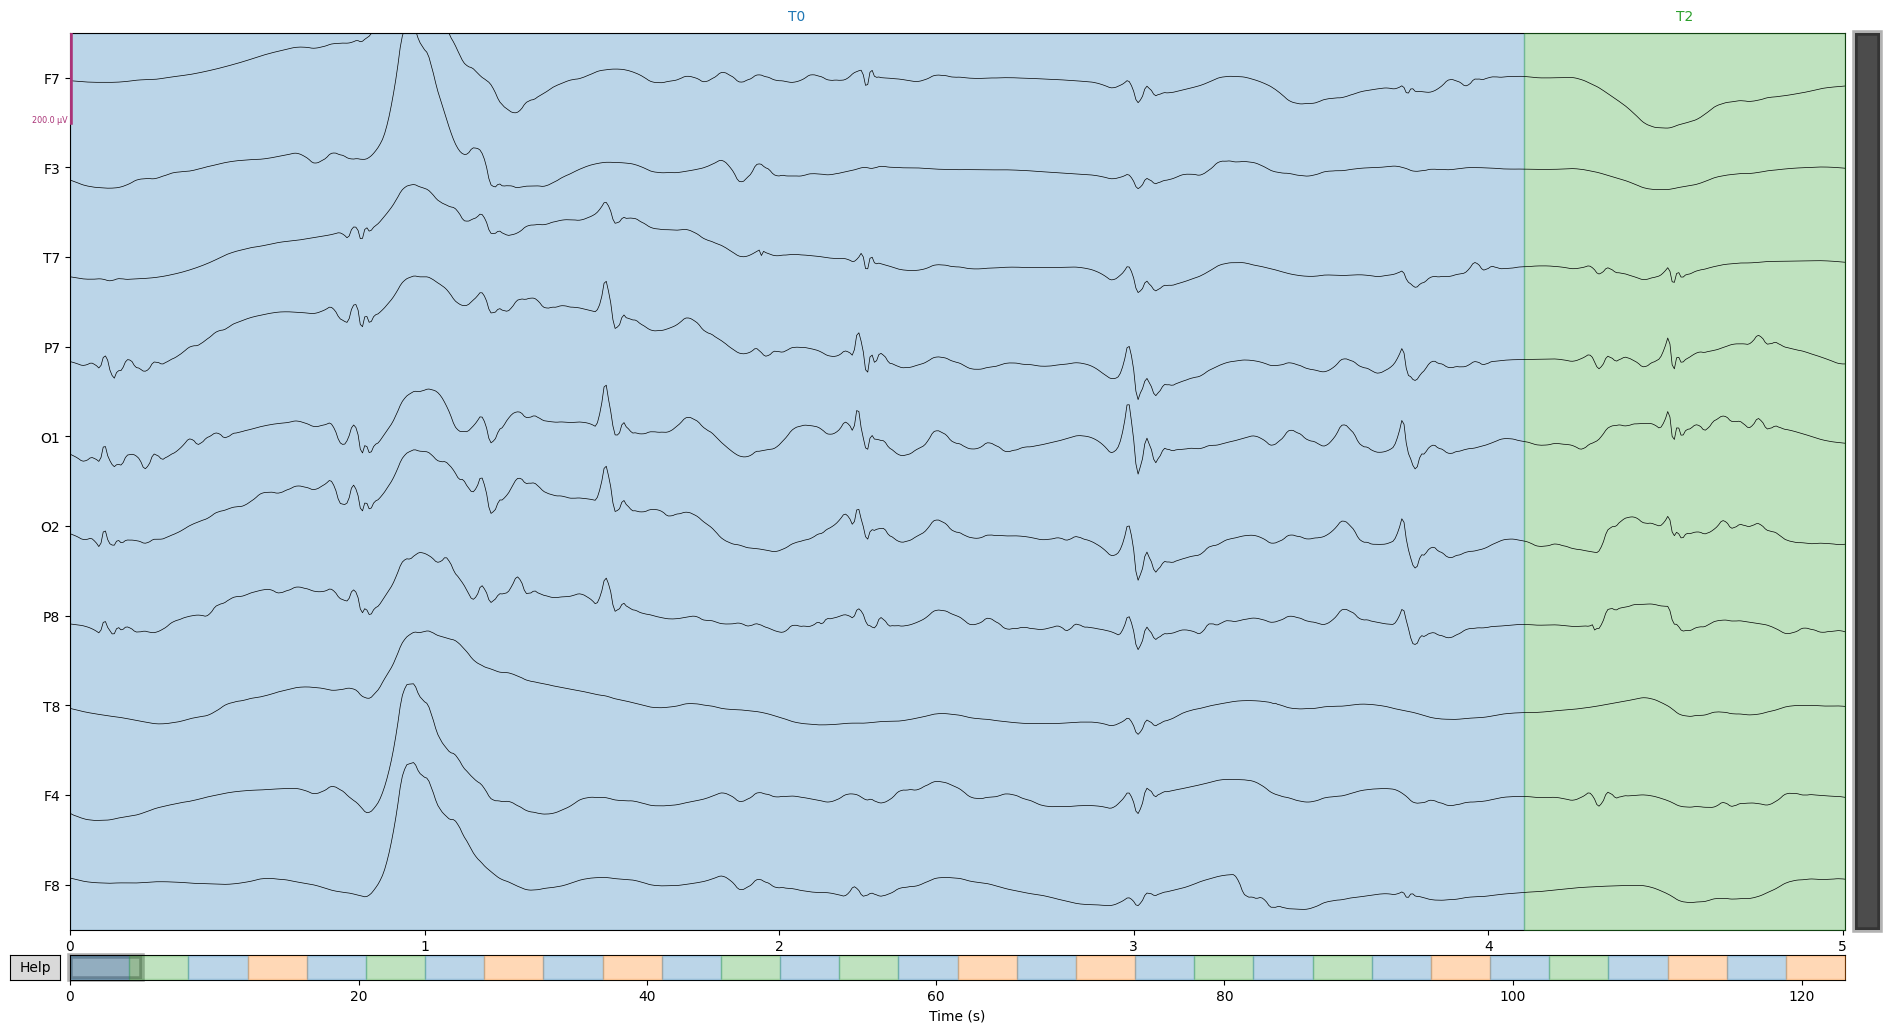

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


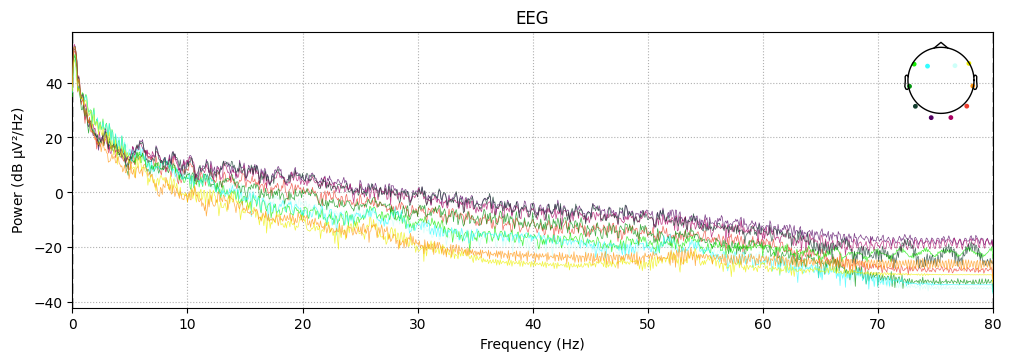

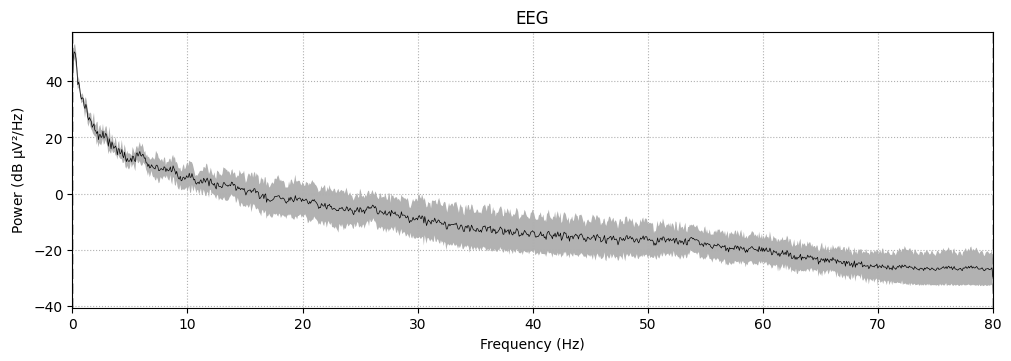

In [60]:
def wavelet_denoising(signal, wavelet='db4', level=5):

    # Wavelet-Decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # calc threshold
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745 * np.sqrt(2 * np.log(len(signal)))
    
    # Thresholding
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    
    #  Rekonstruktion
    return pywt.waverec(coeffs, wavelet)



# Wavelet-Denoising
wavelet_raw = notched_raw.copy()

for ch in wavelet_raw.ch_names:
    eeg_data = wavelet_raw.get_data(picks=[ch]).flatten()
    denoised_data = wavelet_denoising(eeg_data)
    wavelet_raw._data[wavelet_raw.ch_names.index(ch)] = denoised_data
# plot_comparison(notched_raw, denoised_raw, "Wavelet Denoising")

# notched_raw.plot(title="Originaldaten", duration=5, n_channels=len(desired_channels), scalings=0.0001)
wavelet_raw.plot(title="Detrended", duration=5, n_channels=len(desired_channels), scalings=0.0001)

# notched_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
# notched_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)
wavelet_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
wavelet_raw.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)
plt.show()

# Alpha Beta Gamma

Hier wird auf die vorverarbeiteten Daten drei FIR band pass filter angwendet, um die alpha, betta und gamma bänder zu extrahieren

Ein FIR-Bandpassfilter (Finite Impulse Response Bandpass Filter) ist ein Filtertyp, der verwendet wird, um Signale in einem bestimmten Frequenzbereich zu isolieren, während Frequenzen außerhalb dieses Bereichs unterdrückt werden

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 265 samples (1.656 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge:

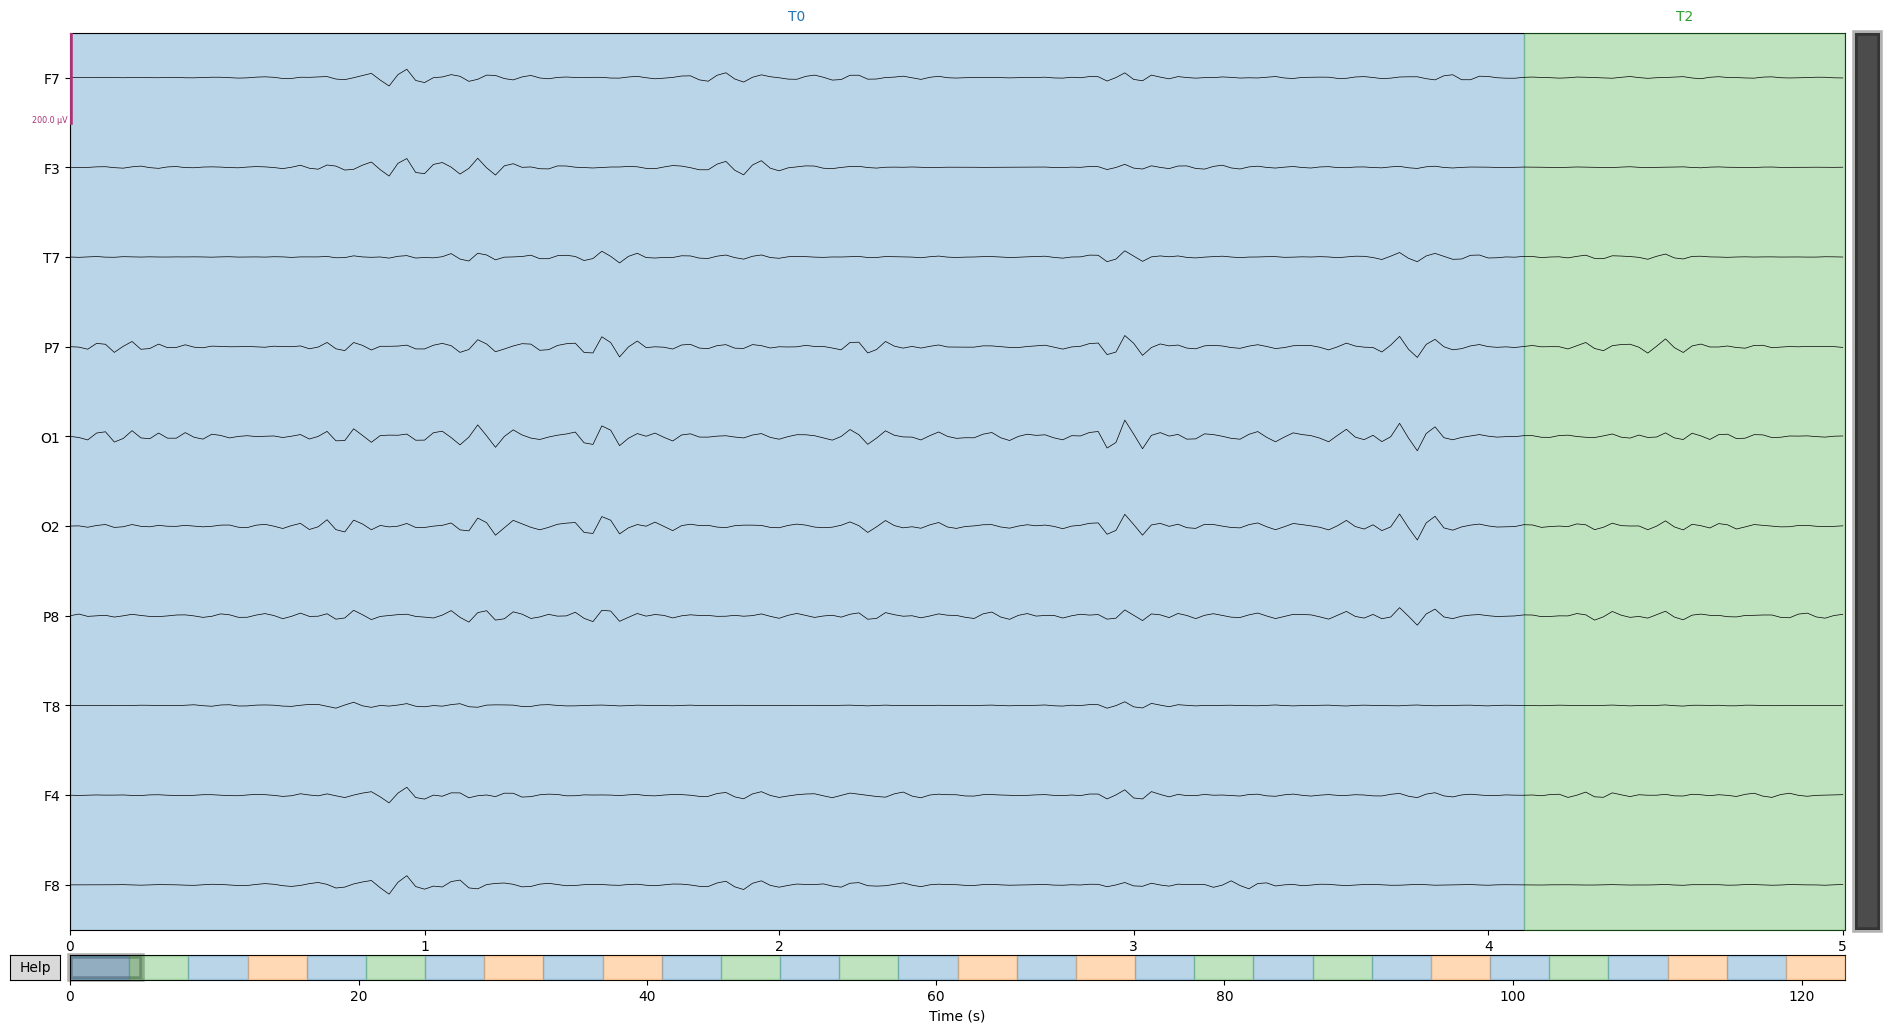

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


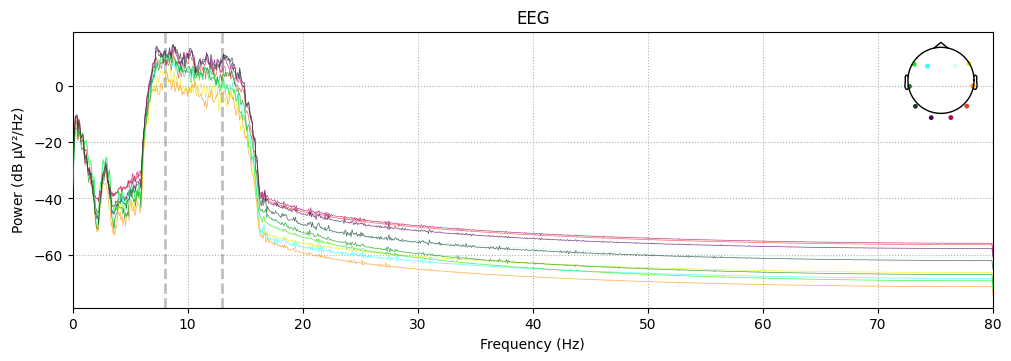

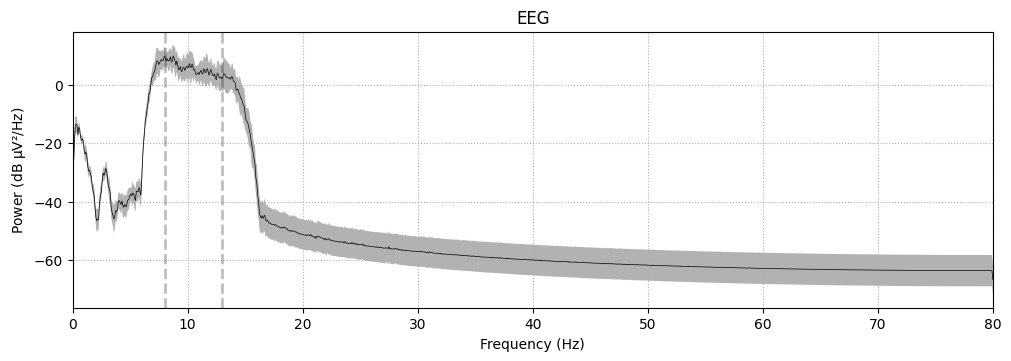

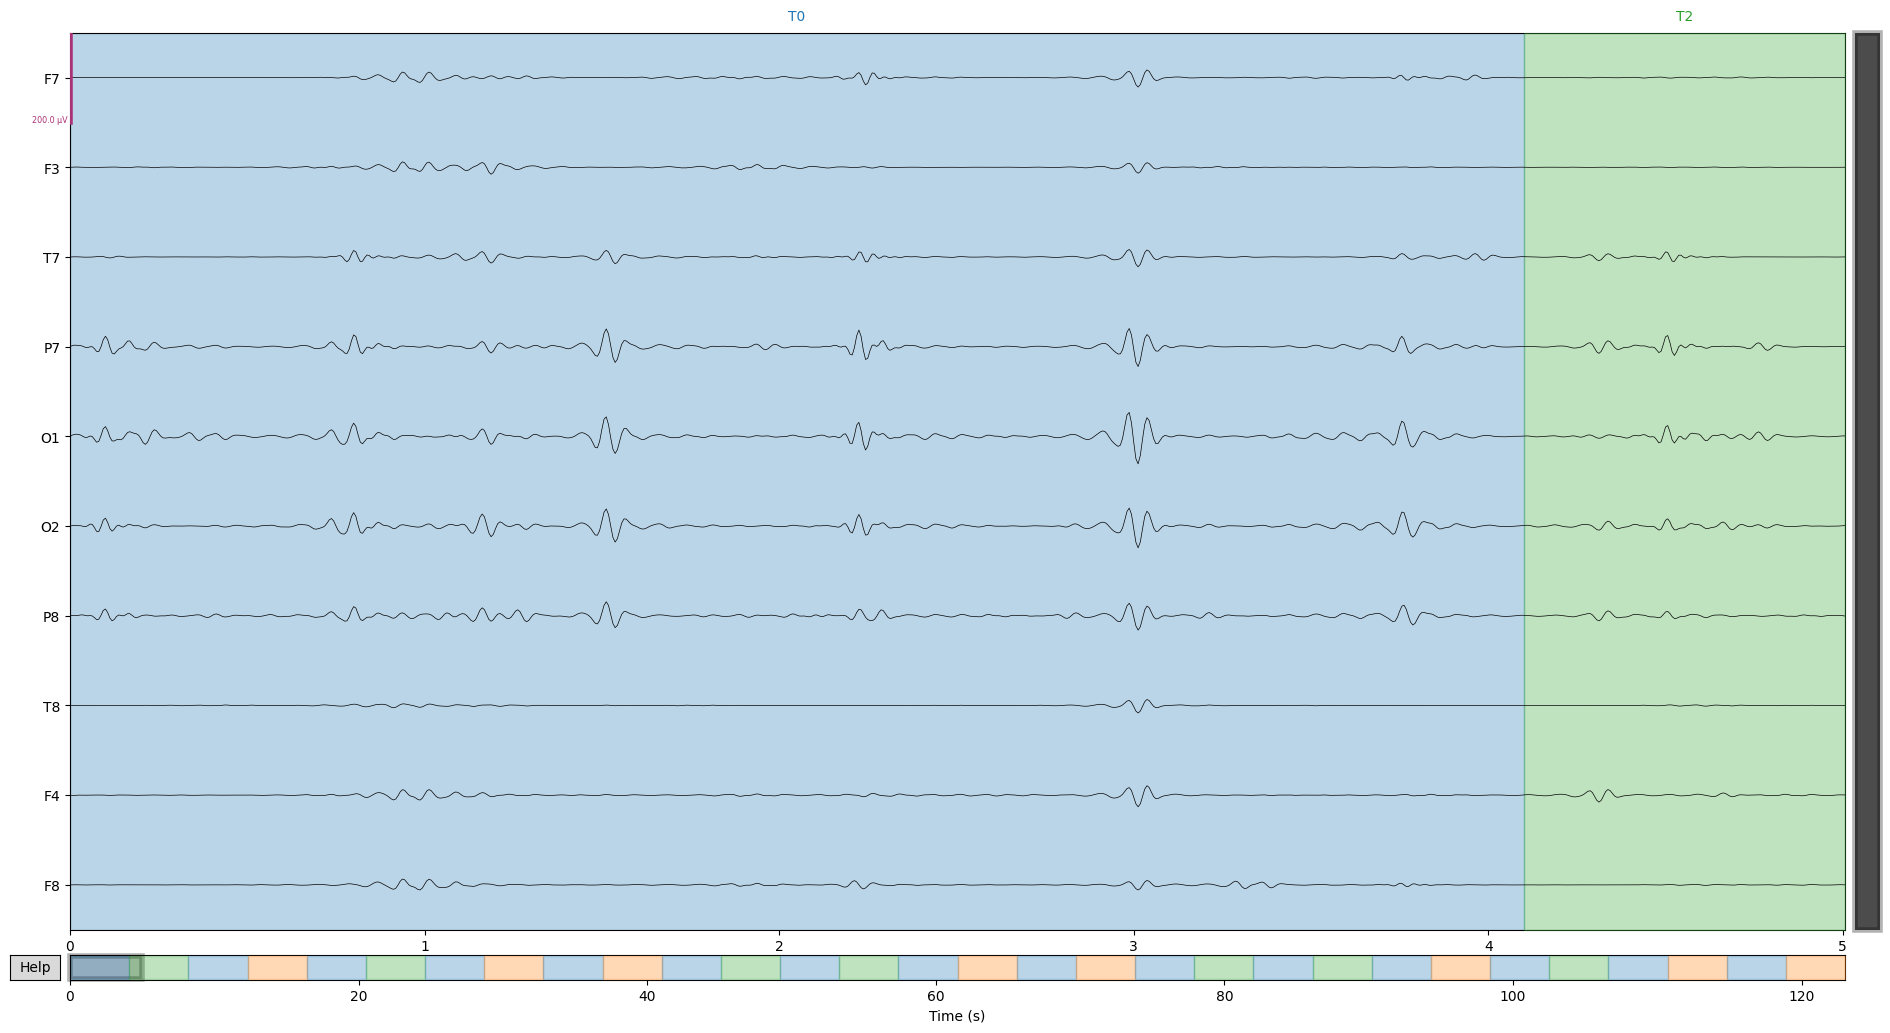

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


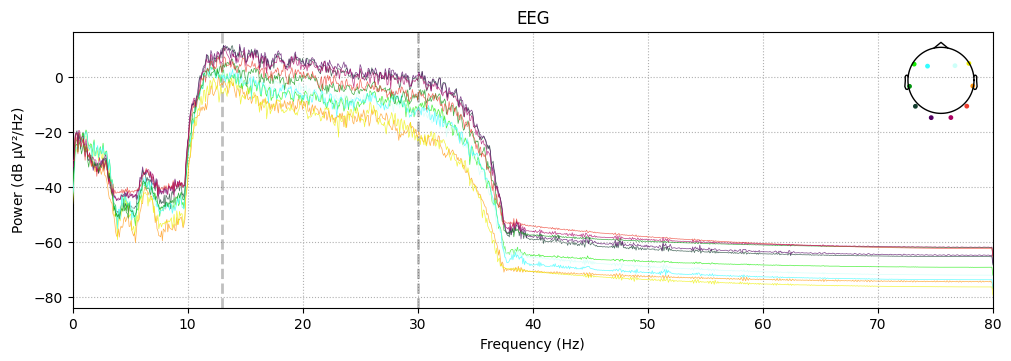

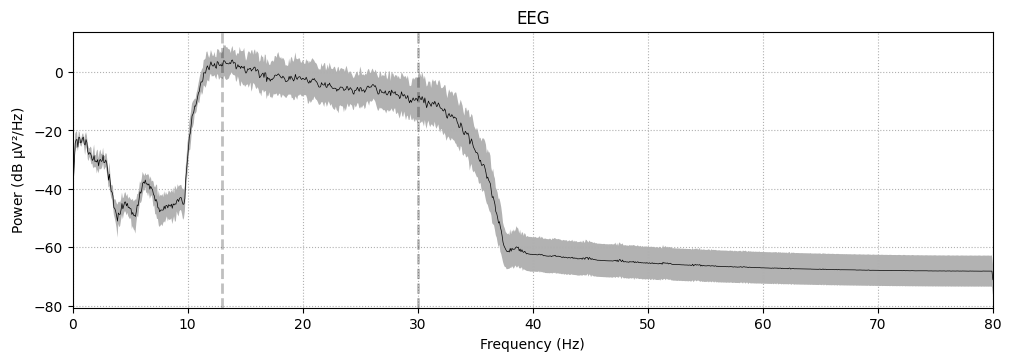

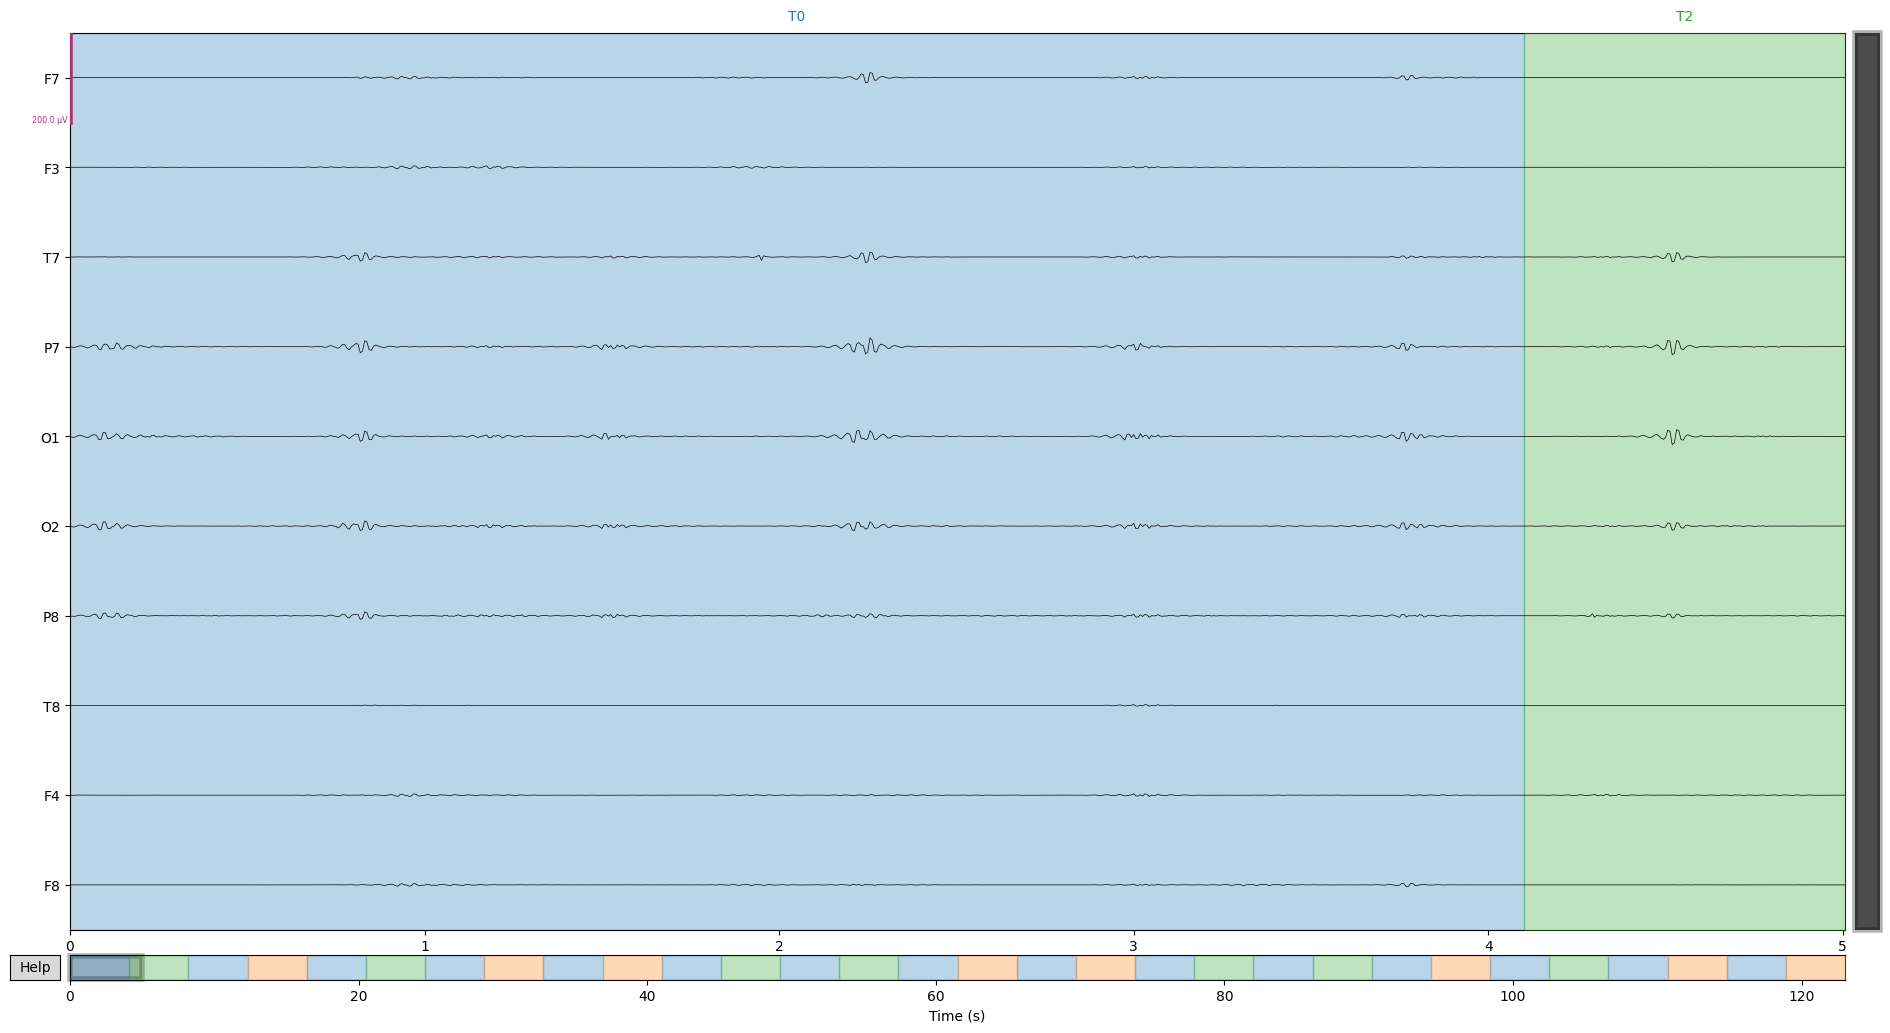

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\starp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


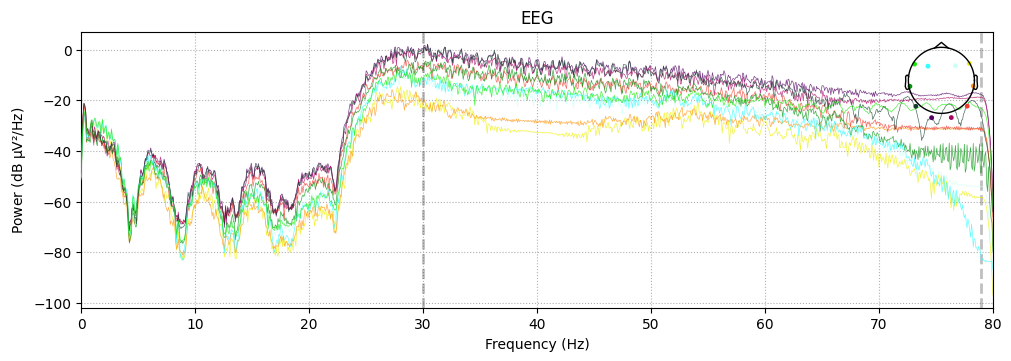

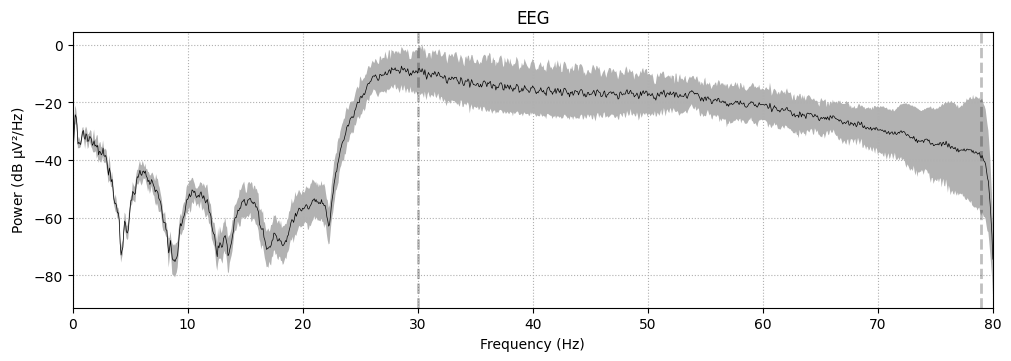

In [61]:
# frequency bands
freq_ranges = {
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 79)
}


filtered_data = {}

# use fir filter
for band, (low_freq, high_freq) in freq_ranges.items():
    filtered_data[band] = wavelet_raw.copy().filter(l_freq=low_freq, h_freq=high_freq, method='fir')


for i, (band, data) in enumerate(filtered_data.items()):
    data.plot( title=f'{band.capitalize()} Band ({freq_ranges[band][0]}-{freq_ranges[band][1]} Hz)', duration=5, n_channels=len(desired_channels), scalings=0.0001)
    data.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False)
    data.compute_psd(fmax=80).plot(picks="data", exclude="bads", amplitude=False, average=True)

plt.show()

# Hjort Parameters and Spectral Entropy (from each band for each channel)

## Hjorth-Parameter

- Aktivität (Activity):
    - Definition: Die Aktivität ist ein Maß für die Gesamtenergie des Signals und wird als Varianz des Signals berechnet. Sie gibt an, wie viel Variation oder "Bewegung" im Signal vorhanden ist.

    - Interpretation: Ein hoher Aktivitätswert deutet auf eine starke elektrische Aktivität im Gehirn hin, während ein niedriger Wert darauf hindeutet, dass das Signal relativ konstant oder ruhig ist.


- Mobilität (Mobility):

    - Definition: Die Mobilität beschreibt die Frequenzkomponenten des Signals. Sie wird als Quadratwurzel der Varianz der ersten Ableitung des Signals geteilt durch die Aktivität berechnet.

    - Interpretation: Ein höherer Mobilitätswert zeigt an, dass das Signal schnellere Frequenzen enthält. Ein Wert nahe 1 deutet auf eine gleichmäßige Verteilung der Frequenzen hin.

 
- Komplexität (Complexity):

    - Definition: Die Komplexität misst, wie sehr sich das Signal von einer reinen Sinuswelle unterscheidet. Sie wird als Verhältnis zwischen der Mobilität der ersten Ableitung und der Mobilität des Signals berechnet.

    - Interpretation: Ein Wert größer als 1 zeigt an, dass das Signal komplexer ist als eine Sinuswelle, während ein Wert nahe 1 darauf hinweist, dass das Signal eher sinusförmig ist.

## Spektrale Entropie

- Definition: Die spektrale Entropie wird aus dem Leistungsdichtespektrum (Power Spectral Density, PSD) des Signals berechnet. Sie quantifiziert, wie gleichmäßig die Energie über verschiedene Frequenzen verteilt ist.

- Interpretation: Ein höherer Wert für die spektrale Entropie deutet auf eine gleichmäßigere Verteilung der Frequenzkomponenten hin, was auf eine größere Unordnung im Signal hindeutet. Niedrigere Werte zeigen an, dass das Signal dominierte Frequenzen hat und weniger variabel ist.


![image info](./images/hjort.PNG)

In [62]:
def hjorth_parameters(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity)
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility
    
    return activity, mobility, complexity

def spectral_entropy(signal, sf, method='welch', nperseg=None, normalize=False):
    if method == 'fft':
        freqs, psd = welch(signal, sf, nperseg=nperseg)
    elif method == 'welch':
        freqs, psd = welch(signal, sf, nperseg=nperseg)
    psd_norm = psd / psd.sum()
    se = entropy(psd_norm)
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

features = {}
for band, data in filtered_data.items():
    features[band] = {
        'hjorth': [],
        'spectral_entropy': []
    }
    for ch in range(data.get_data().shape[0]):
        channel_data = data.get_data()[ch]
        h1, h2, h3 = hjorth_parameters(channel_data)
        se = spectral_entropy(channel_data, data.info['sfreq'])
        features[band]['hjorth'].append((h1, h2, h3))
        features[band]['spectral_entropy'].append(se)

for band, band_features in features.items():
    print(f"{band.capitalize()} Band:")
    for ch in range(len(band_features['hjorth'])):
        print(f"  Channel {ch+1}:")
        print(f"    Hjorth Parameters: Activity={band_features['hjorth'][ch][0]:.12f}, "
              f"Mobility={band_features['hjorth'][ch][1]:.12f}, "
              f"Complexity={band_features['hjorth'][ch][2]:.12f}")
        print(f"    Spectral Entropy: {band_features['spectral_entropy'][ch]:.12f}")


# synthetic_signal = np.random.normal(0, 1, 1000)  # Beispiel für ein zufälliges Signal
# h1, h2, h3 = hjorth_parameters(synthetic_signal)
# print(f"Activity: {h1}, Mobility: {h2}, Complexity: {h3}")

Alpha Band:
  Channel 1:
    Hjorth Parameters: Activity=0.000000000028, Mobility=0.370537400812, Complexity=1.071298191677
    Spectral Entropy: 2.323866082595
  Channel 2:
    Hjorth Parameters: Activity=0.000000000028, Mobility=0.370834695377, Complexity=1.073939413778
    Spectral Entropy: 2.331252889514
  Channel 3:
    Hjorth Parameters: Activity=0.000000000030, Mobility=0.391979041502, Complexity=1.073286924460
    Spectral Entropy: 2.453444235301
  Channel 4:
    Hjorth Parameters: Activity=0.000000000071, Mobility=0.404138252949, Complexity=1.081216593716
    Spectral Entropy: 2.537549967979
  Channel 5:
    Hjorth Parameters: Activity=0.000000000083, Mobility=0.404153207396, Complexity=1.080599334463
    Spectral Entropy: 2.547910407194
  Channel 6:
    Hjorth Parameters: Activity=0.000000000069, Mobility=0.398954204067, Complexity=1.081392617200
    Spectral Entropy: 2.547730954541
  Channel 7:
    Hjorth Parameters: Activity=0.000000000038, Mobility=0.398707110660, Complexi

# Wavelet Decomposition (D1, D2, D3)

In [63]:
wavelet = 'db4'  # Daubechies Wavelet
levels = 3       # amount of decomposition levels (D1, D2, D3)

wavelet_coeffs = {}

# wavelet decomposition for each channel
for ch in range(wavelet_raw.get_data().shape[0]):
    channel_data = wavelet_raw.get_data(picks=[ch]).flatten()
    
    # Wavelet-Decomposition 
    coeffs = pywt.wavedec(channel_data, wavelet, level=levels)
    
    # Koeffizienten (D1, D2, D3)
    wavelet_coeffs[f'Channel_{ch+1}'] = {
        'D1': coeffs[1],
        'D2': coeffs[2],
        'D3': coeffs[3]
    }

for ch, coeffs in wavelet_coeffs.items():
    print(f"{ch}: D1 Coefficients: {coeffs['D1'][:5]}, D2 Coefficients: {coeffs['D2'][:5]}, D3 Coefficients: {coeffs['D3'][:5]}")

Channel_1: D1 Coefficients: [-6.89029612e-07 -2.17253295e-06  1.08134155e-06 -5.08708707e-07
  1.92671214e-07], D2 Coefficients: [ 1.71111831e-07  4.55792488e-07 -3.93314356e-07  1.22428265e-07
  5.73061838e-09], D3 Coefficients: [-8.79590329e-09 -1.67320383e-08  2.48748710e-08 -6.22039821e-22
 -8.20563168e-22]
Channel_2: D1 Coefficients: [-3.07242283e-06 -9.68625502e-06  4.84477954e-06 -2.25696163e-06
  8.35955220e-07], D2 Coefficients: [ 7.64685354e-07  2.03921477e-06 -1.73584804e-06  5.33514106e-07
  2.51894071e-08], D3 Coefficients: [-3.79023816e-08 -7.59301254e-08  1.09339553e-07  3.01755487e-21
 -2.22346149e-21]
Channel_3: D1 Coefficients: [-1.33704298e-06 -4.21219206e-06  2.15280821e-06 -9.74756159e-07
 -4.94066247e-06], D2 Coefficients: [ 3.22431490e-07  8.55557337e-07 -7.27671632e-07  2.20065596e-07
  1.04102257e-08], D3 Coefficients: [-1.52629978e-08 -3.16363871e-08  4.51876225e-08  3.46754113e-21
  1.58818678e-22]
Channel_4: D1 Coefficients: [-2.60970376e-06 -8.17376431e-06 

# Wavelet Enegery and Entropy (from each D)

In [64]:

def calculate_wavelet_energy(coeffs):
    return np.sum(coeffs**2)

def calculate_entropy(coeffs):
    if np.sum(coeffs) == 0:
        return 0
    
    # normalize coefficients
    coeffs_normalized = coeffs / np.sum(coeffs)
    # calculate entropy
    return -np.sum(coeffs_normalized * np.log(coeffs_normalized + 1e-10))  # Hinzufügen von epsilon, um log(0) zu vermeiden

wavelet_features = {}

# calc energy and entropy for each channel and decomposition level
for ch, coeffs in wavelet_coeffs.items():
    wavelet_features[ch] = {
        'D1': {
            'Energy': calculate_wavelet_energy(coeffs['D1']),
            'Entropy': calculate_entropy(coeffs['D1'])
        },
        'D2': {
            'Energy': calculate_wavelet_energy(coeffs['D2']),
            'Entropy': calculate_entropy(coeffs['D2'])
        },
        'D3': {
            'Energy': calculate_wavelet_energy(coeffs['D3']),
            'Entropy': calculate_entropy(coeffs['D3'])
        }
    }

for ch, features in wavelet_features.items():
    print(f"{ch}:")
    for d_level, values in features.items():
        print(f"  {d_level}: Energy = {values['Energy']:.6f}, Entropy = {values['Entropy']:.6f}")

Channel_1:
  D1: Energy = 0.000000, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_2:
  D1: Energy = 0.000000, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_3:
  D1: Energy = 0.000000, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_4:
  D1: Energy = 0.000001, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_5:
  D1: Energy = 0.000002, Entropy = nan
  D2: Energy = 0.000001, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_6:
  D1: Energy = 0.000001, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_7:
  D1: Energy = 0.000001, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 0.000000, Entropy = nan
Channel_8:
  D1: Energy = 0.000000, Entropy = nan
  D2: Energy = 0.000000, Entropy = nan
  D3: Energy = 

C:\Users\starp\AppData\Local\Temp\ipykernel_30364\2552473699.py:11: RuntimeWarning: invalid value encountered in log
  return -np.sum(coeffs_normalized * np.log(coeffs_normalized + 1e-10))  # Hinzufügen von epsilon, um log(0) zu vermeiden


# Empirical Mode Decomposition (1st, 2nd, 3rd IMFs)

[[ 9.36055936e-09 -1.88640525e-09 -9.30688592e-09 ... -2.36942509e-07
  -3.15664052e-07  1.29285554e-07]
 [-6.46501247e-06 -6.85949290e-06 -7.26186168e-06 ...  2.02142076e-05
   2.13304605e-05  2.24383444e-05]]
[[-4.10036318e-08 -3.87247937e-08 -1.49992614e-08 ... -2.81782591e-07
  -5.15853770e-07 -1.06288460e-08]
 [-2.47727166e-05 -2.65914383e-05 -2.84413278e-05 ... -4.46572283e-06
  -2.71873061e-06 -1.01090058e-06]]
[[-1.87485154e-07 -3.20747264e-07 -1.07969433e-07 ... -2.51352259e-07
  -2.54899713e-07  6.92589373e-08]
 [-2.04549429e-05 -2.10904665e-05 -2.20876116e-05 ... -1.12118253e-05
  -1.09972389e-05 -1.04591877e-05]]
[[-3.49187017e-06 -6.22135781e-06 -8.56428075e-06 ... -6.13770873e-07
  -1.44775309e-07  3.23577635e-07]
 [ 1.25145019e-05  1.45667709e-05  1.56616801e-05 ... -8.05263472e-06
  -1.00207093e-05 -8.46658284e-06]
 [-6.02431234e-06 -6.37088638e-06 -6.37033688e-06 ...  6.93264316e-06
   6.78985129e-06  6.38232866e-06]
 [-8.98909597e-07 -1.17017783e-06 -1.25764955e-06 ..

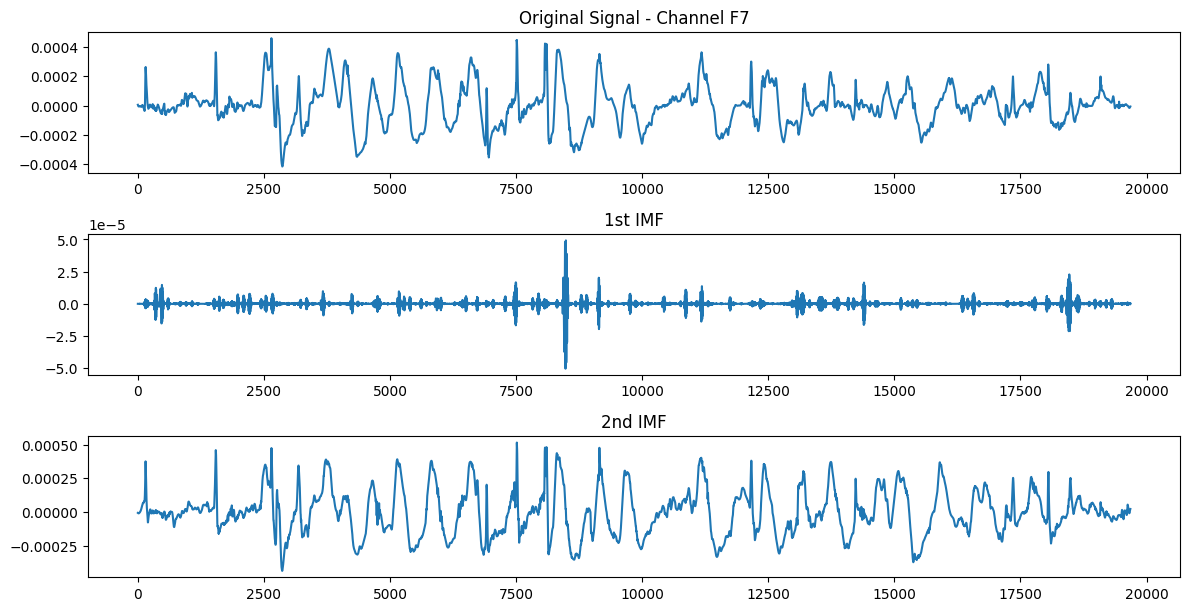

In [65]:
def calculate_imfs(signal, num_imfs=2): #TODO es sollen 3 imfs sein, aber ich bekomme nur zwei
    emd = EMD()
    imfs = emd.emd(signal)
    print(imfs)
    return imfs[:num_imfs]

imfs_dict = {}
for ch in wavelet_raw.ch_names:
    eeg_data = wavelet_raw.get_data(picks=[ch]).flatten()
    imfs = calculate_imfs(eeg_data)
    imfs_dict[ch] = imfs

print(f"IMFs for channel {wavelet_raw.ch_names[0]}:")
for i, imf in enumerate(imfs_dict[wavelet_raw.ch_names[0]]):
    print(f"  IMF {i+1}: {imf[:5]}")

channel_name = wavelet_raw.ch_names[0]
imf1, imf2 = imfs_dict[channel_name] #TODO es sollen 3 imfs sein, aber ich bekomme nur zwei

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(eeg_data)
plt.title(f'Original Signal - Channel {channel_name}')

plt.subplot(4, 1, 2)
plt.plot(imf1)
plt.title('1st IMF')

plt.subplot(4, 1, 3)
plt.plot(imf2)
plt.title('2nd IMF')

# plt.subplot(4, 1, 4)
# plt.plot(imf3)
# plt.title('3rd IMF')

plt.tight_layout()
plt.show()

# IMF Energy and Entropy (from each IMF)

In [66]:
def calculate_imf_features(imf):
    energy = np.sum(imf**2)
    
    f, Pxx = welch(imf, fs=1, nperseg=len(imf))
    
    Pxx_norm = Pxx / np.sum(Pxx)
    
    entropy_value = entropy(Pxx_norm)
    
    return energy, entropy_value

imf_features = {}
for ch in imfs_dict:
    imf_features[ch] = []
    for imf in imfs_dict[ch]:
        energy, entropy_value = calculate_imf_features(imf)
        imf_features[ch].append((energy, entropy_value))


for ch, features in imf_features.items():
    print(f"Features for channel {ch}:")
    for i, (energy, entropy_value) in enumerate(features):
        print(f"  IMF {i+1}: Energy = {energy:.2e}, Entropy = {entropy_value:.2f}")


Features for channel F7:
  IMF 1: Energy = 1.46e-07, Entropy = 7.67
  IMF 2: Energy = 5.61e-04, Entropy = 4.07
Features for channel F3:
  IMF 1: Energy = 6.70e-08, Entropy = 8.18
  IMF 2: Energy = 3.81e-04, Entropy = 4.30
Features for channel T7:
  IMF 1: Energy = 3.75e-07, Entropy = 7.74
  IMF 2: Energy = 4.87e-04, Entropy = 3.77
Features for channel P7:
  IMF 1: Energy = 8.65e-07, Entropy = 8.11
  IMF 2: Energy = 1.02e-06, Entropy = 7.53
Features for channel O1:
  IMF 1: Energy = 1.42e-06, Entropy = 8.19
  IMF 2: Energy = 1.40e-06, Entropy = 7.45
Features for channel O2:
  IMF 1: Energy = 7.43e-07, Entropy = 8.23
  IMF 2: Energy = 8.98e-07, Entropy = 7.52
Features for channel P8:
  IMF 1: Energy = 3.02e-07, Entropy = 8.17
  IMF 2: Energy = 7.89e-04, Entropy = 3.63
Features for channel T8:
  IMF 1: Energy = 2.10e-08, Entropy = 8.03
  IMF 2: Energy = 1.10e-03, Entropy = 3.67
Features for channel F4:
  IMF 1: Energy = 1.15e-07, Entropy = 7.82
  IMF 2: Energy = 2.57e-04, Entropy = 4.65
F